In [31]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader


# from model.cnn_lstm_64_128_200_32 import CNN_LSTM
from model.early_stopping import EarlyStopping
from dataset.preparetion import generate_data
from dataset.travel_time_dataset import TravelTimeDataset

In [32]:
cfg = {
    'data': {
        'path': 'E:/data/time_series_clean/start_stop/1.csv',
        'feature': 'delta_t',
        'window_size': 21,
        'train_split_size': 0.6,
        'val_split_size': 0.2
    },
    'plots': {
        'show_plots': True,
        'color_actual': '#001F3F',
        'color_train': '#3D9970',
        'color_val': '#0074D9',
        'color_test': '#FF4136',
        'color_pred_train': '#3D9970',
        'color_pred_val': '#0074D9',
        'color_pred_test': '#FF4136',
    },
    'optimizer': {
        'name': 'adam',
        'lr': 0.001,
        'beta': (0.9, 0.999),
        'eps': 1e-8,
        'momentum': 0.9,
        'weight_decay': 1e-6,
    },
    'scheduler': {
        'step_size': 10,
    },
    'train': {
        'device': 'cuda',
        'batch_size': 16,
        'num_epoch': 200,
        'checkpoint_path': 'E:/checkpoints/cnn_lstm',
    }
}

# Load data

In [33]:
def split_data_time_over(period, cfg):
    time = [[]] * (21//period)
    travel_time = [[]] * (21//period)
    num_data_points_list = []
    df_list = []

    df = pd.read_csv(cfg['data']['path'], index_col=0, parse_dates=True)
    num_data_points = len(df)

    data_date = [date for date in df.index]
    data_date = np.array(data_date)

    data_travel_time = [float(df.loc[df.index == date]['delta_t']) for date in df.index]
    data_travel_time = np.array(data_travel_time)

    for part_time_idx in range(21//period):
        for idx in range(num_data_points//21):
            time[part_time_idx] = time[part_time_idx] + data_date[(idx * 21) + (part_time_idx * period):(idx * 21) + period + (part_time_idx * period)].tolist()
            travel_time[part_time_idx] = travel_time[part_time_idx] + data_travel_time[(idx * 21) + (part_time_idx * period):(idx * 21) + period + (part_time_idx * period)].tolist()

        tmp_time = pd.Series(time[part_time_idx], name='datetime')
        tmp_travel_time = pd.Series(travel_time[part_time_idx], name='travel_time')
        df = pd.concat([tmp_time, tmp_travel_time], axis=1)
        df = df.set_index('datetime')

        num_data_points_list.append(len(df))
        df_list.append(df)

    return df_list, num_data_points_list

In [34]:
df, num_data_points_list = split_data_time_over(3, cfg)

# Data preparation: normalize raw data and tran val test split

In [35]:
def timeseries_to_supervised(data, lag=1):
    df =  pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    return df

In [36]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

def inverse_difference(history, yhat, batch_idx, batch_size, size):
    result = []
    for idx in range(len(yhat)):
        interval = ((size + 1) - (batch_idx * batch_size)) - idx
        result.append(yhat[idx] + history[-interval])
    return result

In [37]:
def scale(train, val, test):
    # scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = StandardScaler()
    scaler = scaler.fit(train)

    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)

    val = val.reshape(val.shape[0], val.shape[1])
    val_scaled = scaler.transform(val)

    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, val_scaled, test_scaled

def invert_scale(scaler, X, pred):
    result = []
    for idx in range(len(X)):
        X_tmp = X[idx].reshape(X[idx].shape[1])
        yhat = pred[idx]
        new_row = [x for x in X_tmp] + [yhat]
        array = np.array(new_row, dtype="object")
        array = array.reshape(1, len(array))
        inverted = scaler.inverse_transform(array)
        result.append(inverted[0, -1])
    return result

In [38]:
scaler_list, train_scaled_lists, val_scaled_list, test_scaled_list = [], [], [], []
dataset_train_list, dataset_val_list, dataset_test_list = [], [], []
for idx in range(len(df)):
    diff_values = difference(df[idx]['travel_time'], 1)
    supervised = timeseries_to_supervised(diff_values, cfg['train']['batch_size'])
    supervised_values = supervised.values[cfg['train']['batch_size']:,:]
    train, val, test = supervised_values[:int(supervised_values.shape[0] * (cfg['data']['train_split_size'] - 1)), :], \
                        supervised_values[int(supervised_values.shape[0] * (cfg['data']['train_split_size'] - 1)):int(supervised_values.shape[0] * ((cfg['data']['train_split_size'] + cfg['data']['val_split_size']) - 1)), :], \
                        supervised_values[int(supervised_values.shape[0] * ((cfg['data']['train_split_size'] + cfg['data']['val_split_size']) - 1)):, :]
    scaler, train_scaled, val_scaled, test_scaled = scale(train, val, test)

    scaler_list.append(scaler)
    train_scaled_lists.append(train_scaled)
    val_scaled_list.append(val_scaled)
    test_scaled_list.append(test_scaled)

    # split x/y
    data_x_train, data_y_train = train_scaled[:, 0:-1], train_scaled[:, -1]
    data_x_val, data_y_val = val_scaled[:, 0:-1], val_scaled[:, -1]
    data_x_test, data_y_test = test_scaled[:, 0:-1], test_scaled[:, -1]
    print(f"Train data shape: {data_x_train.shape} {data_y_train.shape}")
    print(f"Validation data shape: {data_x_val.shape} {data_y_val.shape}")
    print(f"Test data shape: {data_x_test.shape} {data_y_test.shape}")

    # create travel time data
    dataset_train = TravelTimeDataset(data_x_train, data_y_train)
    dataset_val = TravelTimeDataset(data_x_val, data_y_val)
    dataset_test = TravelTimeDataset(data_x_test, data_y_test)
    print(f"Train data for model shape: {dataset_train.x.shape} {dataset_train.y.shape}")
    print(f"Validation data for model shape: {dataset_val.x.shape} {dataset_val.y.shape}")
    print(f"Test data for model shape: {dataset_test.x.shape} {dataset_test.y.shape}")
    print(f"====================================================================================")

    dataset_train_list.append(dataset_train)
    dataset_val_list.append(dataset_val)
    dataset_test_list.append(dataset_test)

Train data shape: (626, 16) (626,)
Validation data shape: (208, 16) (208,)
Test data shape: (208, 16) (208,)
Train data for model shape: (626, 1, 16) (626,)
Validation data for model shape: (208, 1, 16) (208,)
Test data for model shape: (208, 1, 16) (208,)
Train data shape: (626, 16) (626,)
Validation data shape: (208, 16) (208,)
Test data shape: (208, 16) (208,)
Train data for model shape: (626, 1, 16) (626,)
Validation data for model shape: (208, 1, 16) (208,)
Test data for model shape: (208, 1, 16) (208,)
Train data shape: (626, 16) (626,)
Validation data shape: (208, 16) (208,)
Test data shape: (208, 16) (208,)
Train data for model shape: (626, 1, 16) (626,)
Validation data for model shape: (208, 1, 16) (208,)
Test data for model shape: (208, 1, 16) (208,)
Train data shape: (626, 16) (626,)
Validation data shape: (208, 16) (208,)
Test data shape: (208, 16) (208,)
Train data for model shape: (626, 1, 16) (626,)
Validation data for model shape: (208, 1, 16) (208,)
Test data for model

In [39]:
df = pd.read_csv(cfg['data']['path'], index_col=0, parse_dates=True)

scaler_list, train_scaled_lists, val_scaled_list, test_scaled_list = [], [], [], []
dataset_train_list, dataset_val_list, dataset_test_list = [], [], []

diff_values = difference(df['delta_t'], 1)
supervised = timeseries_to_supervised(diff_values, cfg['train']['batch_size'])
supervised_values = supervised.values[cfg['train']['batch_size']:,:]
train, val, test = supervised_values[:int(supervised_values.shape[0] * (cfg['data']['train_split_size'] - 1)), :], \
                    supervised_values[int(supervised_values.shape[0] * (cfg['data']['train_split_size'] - 1)):int(supervised_values.shape[0] * ((cfg['data']['train_split_size'] + cfg['data']['val_split_size']) - 1)), :], \
                    supervised_values[int(supervised_values.shape[0] * ((cfg['data']['train_split_size'] + cfg['data']['val_split_size']) - 1)):, :]
scaler, train_scaled, val_scaled, test_scaled = scale(train, val, test)

scaler_list.append(scaler)
train_scaled_lists.append(train_scaled)
val_scaled_list.append(val_scaled)
test_scaled_list.append(test_scaled)

# split x/y
data_x_train, data_y_train = train_scaled[:, 0:-1], train_scaled[:, -1]
data_x_val, data_y_val = val_scaled[:, 0:-1], val_scaled[:, -1]
data_x_test, data_y_test = test_scaled[:, 0:-1], test_scaled[:, -1]
print(f"Train data shape: {data_x_train.shape} {data_y_train.shape}")
print(f"Validation data shape: {data_x_val.shape} {data_y_val.shape}")
print(f"Test data shape: {data_x_test.shape} {data_y_test.shape}")

# create travel time data
dataset_train = TravelTimeDataset(data_x_train, data_y_train)
dataset_val = TravelTimeDataset(data_x_val, data_y_val)
dataset_test = TravelTimeDataset(data_x_test, data_y_test)
print(f"Train data for model shape: {dataset_train.x.shape} {dataset_train.y.shape}")
print(f"Validation data for model shape: {dataset_val.x.shape} {dataset_val.y.shape}")
print(f"Test data for model shape: {dataset_test.x.shape} {dataset_test.y.shape}")
print(f"====================================================================================")

dataset_train_list.append(dataset_train)
dataset_val_list.append(dataset_val)
dataset_test_list.append(dataset_test)

Train data shape: (4438, 16) (4438,)
Validation data shape: (1479, 16) (1479,)
Test data shape: (1479, 16) (1479,)
Train data for model shape: (4438, 1, 16) (4438,)
Validation data for model shape: (1479, 1, 16) (1479,)
Test data for model shape: (1479, 1, 16) (1479,)


In [40]:
# diff_values = difference(df[0]['travel_time'], 1)

In [41]:
# supervised = timeseries_to_supervised(diff_values, 9)

In [42]:
# supervised_values = supervised.values[9:,:]

In [43]:
# train, val, test = supervised_values[0:int(supervised_values.shape[0] * (-0.4)), :], \
#     supervised_values[int(supervised_values.shape[0] *(-0.4)):int(supervised_values.shape[0] *(-0.2)), :],\
#     supervised_values[int(supervised_values.shape[0] *(-0.2)):, :]

In [44]:
# scaler, train_scaled, val_scaled, test_scaled = scale(train, val, test)

In [45]:
# data_x_train, data_y_train = train_scaled[:, 0:-1], train_scaled[:, -1]
# data_x_val, data_y_val = val_scaled[:, 0:-1], val_scaled[:, -1]
# data_x_test, data_y_test = test_scaled[:, 0:-1], test_scaled[:, -1]

In [46]:
# print(f"Train data shape: {data_x_train.shape} {data_y_train.shape}")
# print(f"Validation data shape: {data_x_val.shape} {data_y_val.shape}")
# print(f"Test data shape: {data_x_test.shape} {data_y_test.shape}")

In [47]:
# dataset_train = TravelTimeDataset(data_x_train, data_y_train)
# dataset_val = TravelTimeDataset(data_x_val, data_y_val)
# dataset_test = TravelTimeDataset(data_x_test, data_y_test)
# print(f"Train data for model shape: {dataset_train.x.shape} {dataset_train.y.shape}")
# print(f"Validation data for model shape: {dataset_val.x.shape} {dataset_val.y.shape}")
# print(f"Test data for model shape: {dataset_test.x.shape} {dataset_test.y.shape}")

# Define CNN-LSTM model

In [48]:
class CNN_Block(nn.Module):
    def __init__(self):
        super(CNN_Block, self).__init__()
        self.conv_1_out = [32, 64, 128]
        self.conv_2_out = [32, 64, 128]
        self.conv_kernel_size = [2, 3]

        self.conv_1 = nn.Conv1d(1, 64, kernel_size=self.conv_kernel_size[0], stride=1)
        self.conv_2 = nn.Conv1d(64, 128, kernel_size=self.conv_kernel_size[0], stride=1)
        self.maxpool_1 = nn.MaxPool1d(kernel_size=2)

    def forward(self, x):
        out = F.relu(self.conv_1(x))
        out = F.relu(self.conv_2(out))
        out = self.maxpool_1(out)

        return out

In [49]:
class LSTM_Block(nn.Module):
    def __init__(self):
        super(LSTM_Block, self).__init__()
        self.lstm_in = [32, 64, 128]
        self.lstm_hidden = [64, 128, 200, 256]
        self.linear_out = [32, 64]
        self.dropout = [0.1, 0.2, 0.3]

        self.lstm_1 = nn.LSTM(
            input_size=128,
            hidden_size=200,
            num_layers=1,
            batch_first=True,
        )
        self.fc_1 = nn.Linear(200, 32)
        self.dropout_1 = nn.Dropout(0.2)

    def forward(self, x):
        out, _ = self.lstm_1(x)
        out = out[:, -1, :]
        out = F.relu(self.fc_1(out))
        out = self.dropout_1(out)

        return out

In [50]:
class CNN_LSTM(nn.Module):
    def __init__(self):
        super(CNN_LSTM, self).__init__()
        self.linear_in = [32, 64]
        self.cnn_block = CNN_Block()
        self.lstm_block = LSTM_Block()
        self.out_block = nn.Linear(32, 1)

    def forward(self, x):
        # CNN block
        out = self.cnn_block(x)
        out = out.view(out.shape[0], out.shape[2], out.shape[1])

        # print(out.shape)
        # LSTM block
        out = self.lstm_block(out)
        
        # Output layer
        out = self.out_block(out)

        return out

In [51]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=10, num_layers=1, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(10, 1)

    def forward(self, x):
        x = x.reshape(x.shape[0], x.shape[2], x.shape[1])
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc(out)

        return out

In [52]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

# Model training

In [53]:
def train(dataset_train, dataset_val, model, cfg, idx, count):
    # init tool for train model
    # craete dataloader
    train_dataloader = DataLoader(dataset_train, batch_size=cfg['train']['batch_size'], shuffle=True)
    val_dataloader = DataLoader(dataset_val, batch_size=cfg['train']['batch_size'], shuffle=True)

    # define optimizer, sheduler and loss function
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=cfg['optimizer']['lr'])
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=cfg['scheduler']['step_size'], gamma=0.5)
    early_stopping = EarlyStopping(patience=20, verbose=False, path=cfg['train']['checkpoint_path'])

    train_losses = []
    valid_losses = []
    avg_train_losses = []
    avg_valid_losses = []
    
    for epoch in range(cfg['train']['num_epoch']):
        # print(f"Epoch: {epoch + 1}")

        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (x, y) in enumerate(train_dataloader):
            batch_size = x.shape[0]

            x = x.to(cfg['train']['device'])
            y = y.to(cfg['train']['device'])
            
            # prediction
            pred = model(x.float())
            loss = criterion(pred[:,0], y.float())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # add train loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (x, y) in enumerate(val_dataloader):
            batch_size = x.shape[0]

            x = x.to(cfg['train']['device'])
            y = y.to(cfg['train']['device'])

            pred = model(x.float())
            loss = criterion(pred[:,0], y.float())

            # add valid loss
            valid_losses.append(loss.item())

        # update scheduler
        lr = scheduler.get_last_lr()[0]
        scheduler.step()

        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        # print(f"[Epoch: {epoch + 1} / {cfg['train']['num_epoch']} || train_loss: {train_loss:.5f} || valid_loss: {valid_loss:.5f} || lr: {lr:.5f}]")

        train_losses = []
        valid_losses = []

        early_stopping(valid_loss, epoch, model, cfg, idx, count)

        if early_stopping.early_stop:
            # print('Early stopping')
            break

    return avg_train_losses, avg_valid_losses, early_stopping, model

# Model evaluation

In [54]:
def eval(idx, actual_data, dataset_test, scaler, model, cfg, best_model_name, plot=False):
    # init tool for train model
    # craete dataloader
    test_dataloader = DataLoader(dataset_test, batch_size=cfg['train']['batch_size'], shuffle=False)

    checkpoint = torch.load(os.path.join(cfg['train']['checkpoint_path'], best_model_name + '.pth'))
    model.load_state_dict(checkpoint['net'])

    predicted_test = []

    model.eval()
    for batch_idx, (x, y) in enumerate(test_dataloader):
        x = x.to(cfg['train']['device'])
        pred = model(x.float())
        pred = pred.cpu().detach().numpy()
        pred = invert_scale(scaler, x, pred)
        pred = inverse_difference(actual_data, pred, batch_idx, cfg['train']['batch_size'], len(test_scaled))
        predicted_test += pred


    actual = actual_data[-len(test_scaled):].to_list()

    mse = mean_squared_error(actual, predicted_test)
    rmse = math.sqrt(mean_squared_error(actual, predicted_test))
    mae = mean_absolute_error(actual, predicted_test)

    # print(f"MSE : {mse}")
    # print(f"RMSE : {rmse}")
    # print(f"MAE : {mae}")

    if plot:
        road = (cfg['data']['path'].split('/')[-1]).split('.')[0]
        path = cfg['data']['path'].split('/')[-2]

        to_plot_data_y_test_subset = actual
        to_plot_predicted_test = predicted_test

        idx = np.arange(0, len(actual))

        #plot
        fig = plt.figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(idx, to_plot_data_y_test_subset, label='Actual travel time', color=cfg['plots']['color_actual'])
        plt.plot(idx, to_plot_predicted_test, label='Predicted travel time (test)', color=cfg['plots']['color_pred_test'])
        plt.title(f"Examine predicted travel time on test data portion of road {road} ({path}) [MSE: {mse:.3f} | RMSE: {rmse:.3f} | MAE: {mae:.3f}]")
        plt.grid(b=None, which='major', axis='y', linestyle='--')
        plt.legend()
        plt.show()

    return mse, rmse, mae

# Modified

1


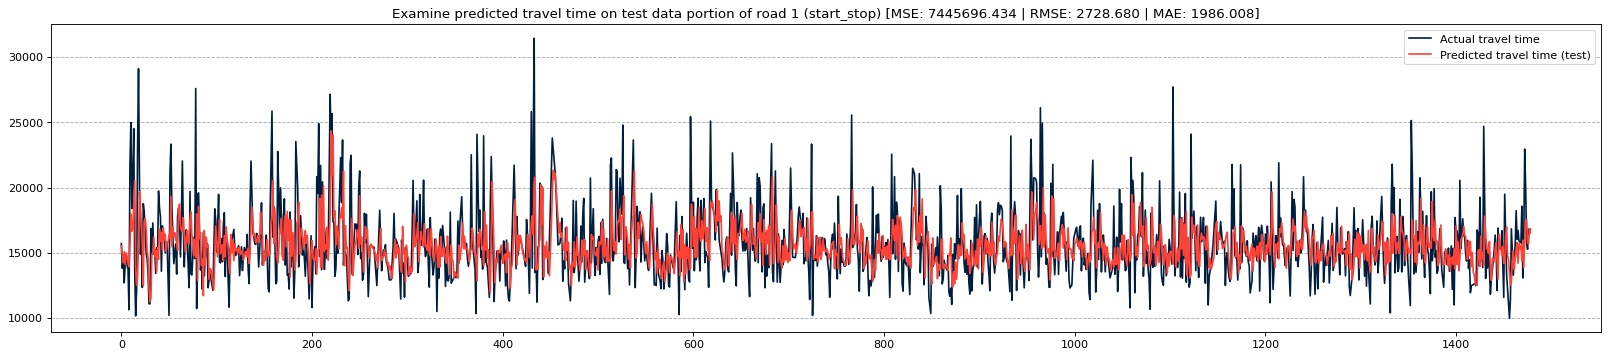

time : 0
MSE : 7445696.434188742 || RMSE : 2728.6803466490433 || MAE : 1986.0077523352234


In [55]:
result = []
print(len(scaler_list))
for idx in range(len(scaler_list)):
    model = CNN_LSTM()
    model.apply(init_weights)
    if torch.cuda.is_available():
        cfg['train']['device'] = 'cuda'
    else:
        cfg['train']['device'] = 'cpu'
    model = model.to(cfg['train']['device'])

    train_losses, valid_losses, early_stopping, model = train(dataset_train_list[idx], dataset_val_list[idx], model, cfg, idx, 0)

    mse, rmse, mae = eval(idx, df['delta_t'], dataset_test_list[idx], scaler_list[idx], model, cfg, f"cnn_lstm_time_{idx}_{0}", True)

    print(f"time : {idx}")
    print(f"MSE : {mse} || RMSE : {rmse} || MAE : {mae}")
    print(f"==================================================================================")

    result.append({
        'name': f"time-{idx}",
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
    })

# Check Normalize

In [99]:
test_dataloader = DataLoader(dataset_test, batch_size=cfg['train']['batch_size'], shuffle=False)
result = []
for batch_idx, (x, y) in enumerate(test_dataloader):
    rev = invert_scale(scaler, x, y)
    rev = inverse_difference(df[0]['travel_time'], rev, batch_idx, cfg['train']['batch_size'], len(test_scaled))
    result += rev

In [627]:
def plot_series(series, series_2):
    plt.figure(figsize=(20, 6))
    idx = np.arange(0, len(series))
    plt.plot(idx, series, color='red')
    plt.plot(idx, series_2, color='blue')

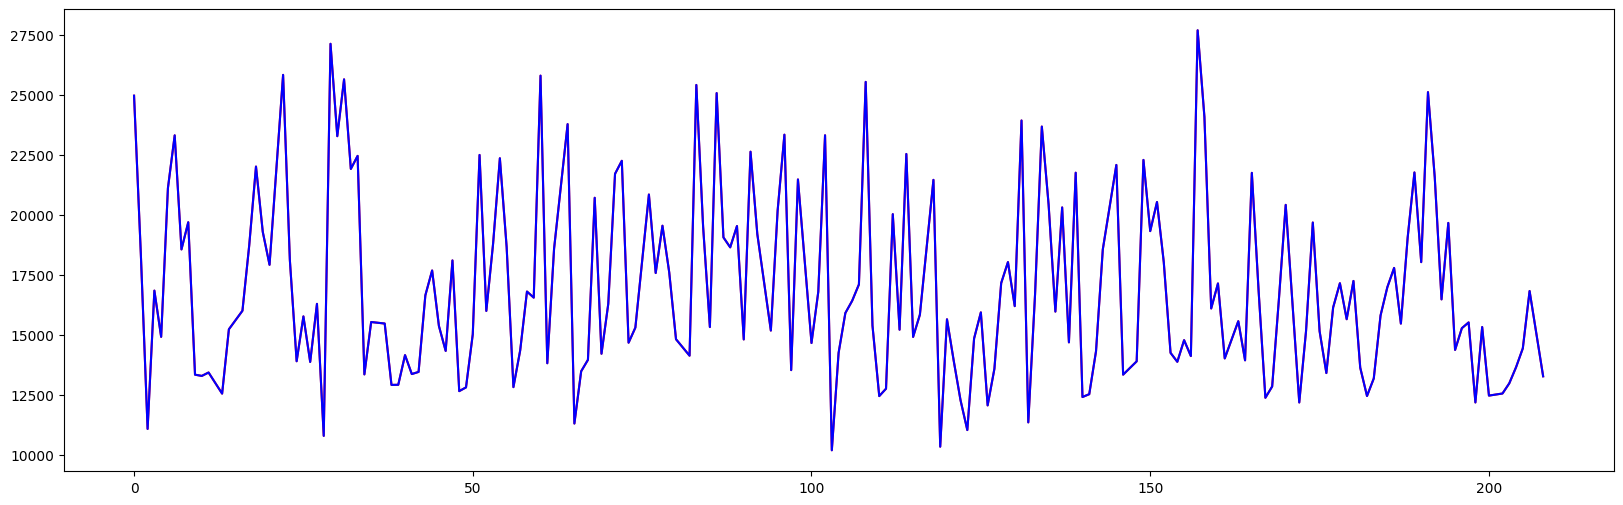

In [628]:
plot_series(result, df[0]['travel_time'][-len(test_scaled):])
plt.show()